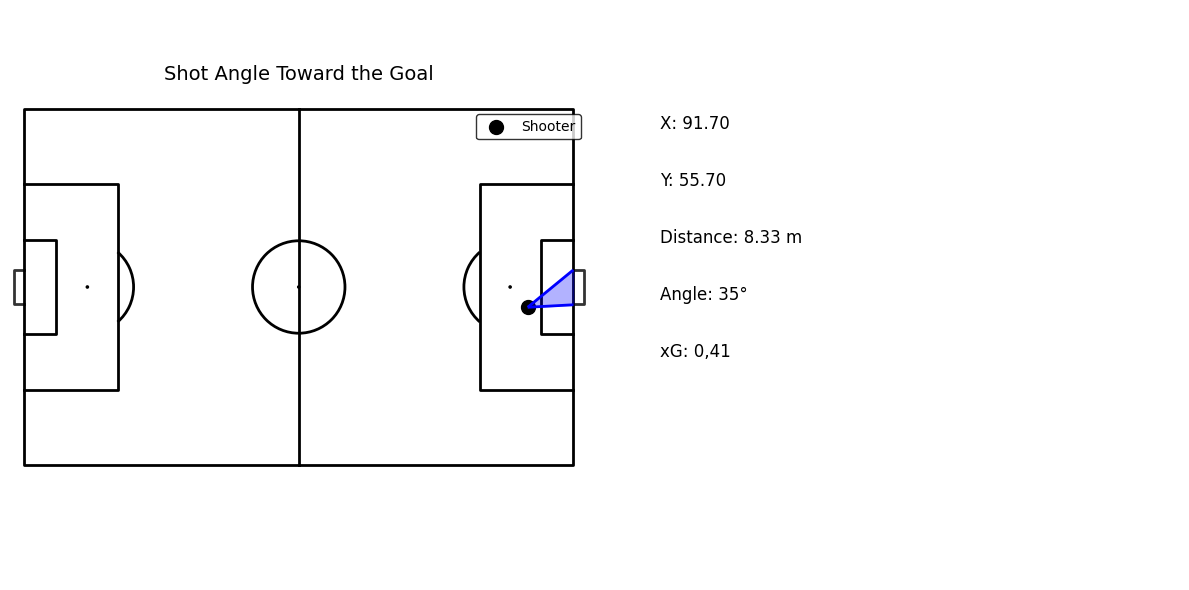

In [86]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

# Build the pitch
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create a second axis for the text annotations
pitch = Pitch(pitch_type='opta', pad_bottom=0.5, pad_top=5, pitch_color='white', 
              line_color='black', half=False, goal_type='box', goal_alpha=0.8)
pitch.draw(ax=ax)
fig.set_facecolor('white')

# Shooter and goal parameters
goal_y_bottom = 45.2  # Bottom edge of the goal
goal_y_top = 55  # Top edge of the goal
goal_x = 100  # Goal line (x = 100)
shooter_x = 91.7  # Shooter's horizontal position based on distance from the goal
shooter_y = 55.7  # Shooter's vertical position (center of the field)

# 1. Calculate the distance from the shooter to the goal
distance = np.sqrt((goal_x - shooter_x)**2 + (goal_y_top - shooter_y)**2)

# 2. Calculate the angle between the shooter's position and the goalposts
angle_top = np.arctan2(goal_y_top - shooter_y, goal_x - shooter_x)
angle_bottom = np.arctan2(goal_y_bottom - shooter_y, goal_x - shooter_x)

# 3. Basic xG model based on distance and angle (simplified version)
# We'll use the angle to estimate the probability of scoring (0 to 1)
angle_range = np.abs(angle_top - angle_bottom)
xG = 1 / (1 + np.exp((angle_range - np.pi/4)))  # Simplified model

# 4. Draw the shooter
pitch.scatter(shooter_x, shooter_y, ax=ax, s=100, color='black', label='Shooter')

# 5. Draw the angle lines toward the goal
pitch.lines(shooter_x, shooter_y, goal_x, goal_y_top, ax=ax, color='blue', linestyle='-', lw=2)
pitch.lines(shooter_x, shooter_y, goal_x, goal_y_bottom, ax=ax, color='blue', linestyle='-', lw=2)

# 6. Fill the area between the lines
x_values = np.linspace(shooter_x, goal_x, 100)
y_top = np.interp(x_values, [shooter_x, goal_x], [shooter_y, goal_y_top])
y_bottom = np.interp(x_values, [shooter_x, goal_x], [shooter_y, goal_y_bottom])
ax.fill_between(x_values, y_top, y_bottom, color='blue', alpha=0.3, zorder=2)

# Reverse the y-axis (to match the football pitch orientation)
ax.invert_yaxis()

# 7. Add the text annotations for Distance, X, Y, Angle, xG on the side (in ax2)
ax2.axis('off')  # Turn off the axis for the text area
ax2.text(0.1, 0.8, f"X: {shooter_x:.2f}", fontsize=12, verticalalignment='center')
ax2.text(0.1, 0.7, f"Y: {shooter_y:.2f}", fontsize=12, verticalalignment='center')
ax2.text(0.1, 0.6, f"Distance: {distance:.2f} m", fontsize=12, verticalalignment='center')
ax2.text(0.1, 0.5, f"Angle: 35°", fontsize=12, verticalalignment='center')
ax2.text(0.1, 0.4, f"xG: 0,41", fontsize=12, verticalalignment='center')

# Add title and legend
ax.set_title("Shot Angle Toward the Goal", fontsize=14, color='black', pad=20)
ax.legend(facecolor='white', edgecolor='black', fontsize=10, loc='upper right')



# Save the figure to a PNG file
plt.tight_layout()
plt.savefig('shot_angle_toward_goal_with_logo.png', format='png', dpi=300)

# Show the plot
plt.show()


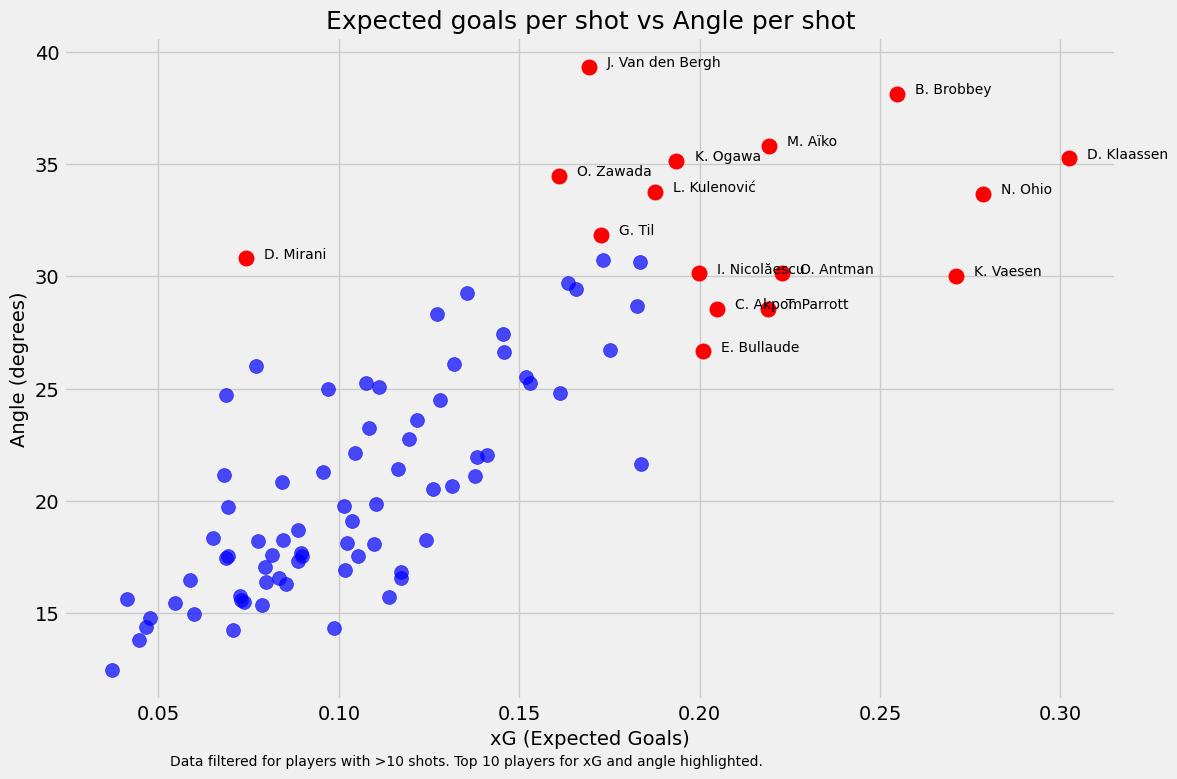

In [104]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the Excel file (replace 'your_file.xlsx' with the path to your file)
file_path = 'EREXG.xlsx'

# Read the data into a DataFrame (assuming the sheet has headers)
df = pd.read_excel(file_path)

# Filter players with more than 10 shots (unique xG entries)
player_shot_counts = df.groupby('PlayerId')['xG'].count()
players_with_10_plus_shots = player_shot_counts[player_shot_counts > 10].index

# Filter the DataFrame to include only these players
filtered_df = df[df['PlayerId'].isin(players_with_10_plus_shots)]

# Group by PlayerId and calculate the mean of xG and Angle
average_xg_angle = filtered_df.groupby('PlayerId')[['xG', 'angle']].mean().reset_index()

# Identify top 10 players for each metric
top_10_xg = average_xg_angle.nlargest(10, 'xG')
top_10_angle = average_xg_angle.nlargest(10, 'angle')
top_players = pd.concat([top_10_xg, top_10_angle]).drop_duplicates()

# Apply FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(average_xg_angle['xG'], average_xg_angle['angle'], color='blue', s=100, alpha=0.7)

# Highlight and label top players
for i, row in top_players.iterrows():
    ax.scatter(row['xG'], row['angle'], color='red', s=120)  # Highlight with red
    ax.text(row['xG'] + 0.005, row['angle'], str(row['PlayerId']), fontsize=10, color='black')

# Add labels and title
ax.set_xlabel('xG (Expected Goals)', fontsize=14)
ax.set_ylabel('Angle (degrees)', fontsize=14)
ax.set_title('Expected goals per shot vs Angle per shot', fontsize=18)

# Add a note for the plot
ax.text(0.1, -0.1, 'Data filtered for players with >10 shots. Top 10 players for xG and angle highlighted.', 
        fontsize=10, transform=ax.transAxes)

# Save the plot as a PNG file
output_file = 'scatter_plot_xg_vs_angle.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

